# Import Packages

In [ ]:
#Tensorflow Version 2.7 is needed 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.io
from tensorflow import keras
import tensorflow as tf
import datetime
from numpy import unique
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Load the simulation data

In [ ]:
# Load EIS data-set
filename="xy_data_131k_regC5_v2.mat"

x=scipy.io.loadmat(filename)["x_data"]
y=scipy.io.loadmat(filename)["y_data"]
y=np.squeeze(y)
x=np.swapaxes(x, 1, 2)


new_shape=x.shape
new_shape=np. asarray(new_shape)
new_shape[-1]=new_shape[-1]+3
new_shape=tuple(new_shape)
new_x = np.zeros(new_shape)
new_x[:, :, :3] = x

y[:,4]=y[:,4]*10**6

y[:,6]=y[:,6]*10**6

y = np.delete(y, [3,5], axis=1)

# Data Augmentation
new_x[:,:,3]=x[:,:,0]*-1
new_x[:,:,4]=x[:,:,1]*-1
new_x[:,:,5]=x[:,:,2]*-1


#split data
x_train, x_test, y_train, y_test = train_test_split(new_x, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Build a DNN model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 6)]          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 64)           12352     
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 128)          131200    
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 256)          262400    
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 512)          524800    
                                                                 
 conv1d_4 (Conv1D)           (None, 100, 768)          787200    
                                                                 
 dense (Dense)               (None, 100, 512)          393728

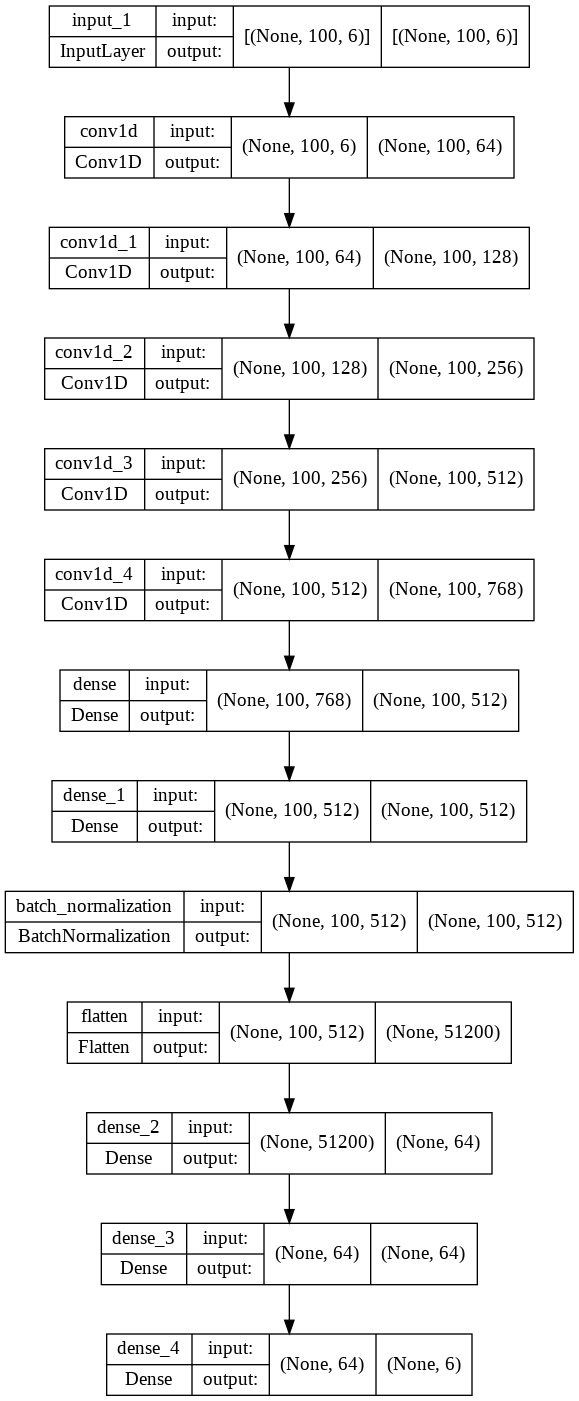

In [ ]:
# Setup the Experiment 
Experiment_name="RegC5"
fn_tmp=filename.split("xy_data_",1)[1].split(".",1)[0]
Experiment_path="EIS_"+fn_tmp+"_model_"+Experiment_name


#build model
initializer = tf.keras.initializers.HeNormal()


def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
#------------------------------------------------------------------------------
    conv1d = keras.layers.Conv1D(filters=64, kernel_size=32, 
                                  padding="same", activation="relu" ,
                                  kernel_initializer=initializer
                                 )(input_layer)

    conv1d = keras.layers.Conv1D(filters=128, kernel_size=16, 
                                  padding="same", activation="relu" ,
                                  kernel_initializer=initializer
                                 )(conv1d)
    
    conv1d = keras.layers.Conv1D(filters=256, kernel_size=8, 
                                  padding="same", activation="relu" ,
                                  kernel_initializer=initializer
                                 )(conv1d)

    conv1d = keras.layers.Conv1D(filters=512, kernel_size=4, 
                                  padding="same", activation="relu" ,
                                  kernel_initializer=initializer
                                 )(conv1d) 

    conv1d = keras.layers.Conv1D(filters=768, kernel_size=2, 
                                  padding="same", activation="relu" ,
                                  kernel_initializer=initializer
                                 )(conv1d) 

#------------------------------------------------------------------------------
    connector = conv1d
    # connector = keras.layers.Flatten()(conv1d)
    # connector = keras.layers.SpatialDropout1D(0.5)(conv1d)
    # connector = keras.layers.BatchNormalization()(connector)
    # connector = keras.layers.GlobalAveragePooling1D()(connector)
    # connector = keras.layers.Flatten()(connector)
#------------------------------------------------------------------------------        
    dense1 = keras.layers.Dense(512, 
                               activation="linear", 
                               kernel_initializer=initializer,
                               )(connector)
    dense1 = keras.layers.Dense(512, 
                               activation="linear", 
                               kernel_initializer=initializer,
                               )(dense1)

    
    dense1 = keras.layers.BatchNormalization()(dense1)
    dense1 = keras.layers.Flatten()(dense1)

    dense1 = keras.layers.Dense(64, 
                               activation="linear", 
                               kernel_initializer=initializer,
                               )(dense1)
    dense1 = keras.layers.Dense(64, 
                               activation="linear", 
                               kernel_initializer=initializer,
                               )(dense1)
                                    
#------------------------------------------------------------------------------
    output_layer1 = keras.layers.Dense(6)(dense1)


    return keras.models.Model(inputs=input_layer, outputs=output_layer1)

model = make_model(input_shape=x_train.shape[1:])

#Model Summarize
print(model.summary())
keras.utils.plot_model(model, show_shapes=True)

# Train a model

In [ ]:

epochs = 500
batch_size = 1024
Experiment_path=Experiment_path+"_"+str(batch_size) 
print(Experiment_path)


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%y_%m_%d") + "/" \
                      + Experiment_path.split("model_",1)[1]  \
                      +"_"+ filename.split("_",-1)[2] \
                      + datetime.datetime.now().strftime("_%m%d%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                          log_dir=log_dir,
                                          histogram_freq=0,
                                          profile_batch=0)

modelpath= Experiment_path \
           + "/" + "model_{epoch:02d}_{val_loss:.2f}_{val_accuracy:.2f}.h5"

callbacks =[
            # keras.callbacks.ModelCheckpoint(
            #     modelpath, save_best_only=True, 
            #     monitor="val_loss",mode="min"
            #     ),
            
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=20, verbose=0,
                mode='min', min_lr=0.000001
                ),
            
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=60, 
                                           verbose=1),
            
            #TqdmCallback(verbose=0),
            tensorboard_callback,         
           ]

model.compile(
              optimizer="adam",
              loss=tf.keras.losses.MeanAbsoluteError(),
              # metrics=[tf.keras.metrics.MeanAbsoluteError()]
             )

history = model.fit(
          x_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks,
          validation_data=(x_test,y_test),
          verbose=1,
                   )



EIS_131k_regC5_v2_model_RegC4_1024
Epoch 1/500
103/103 [==============================] - 41s 293ms/step - loss: 349.9054 - val_loss: 353.2434 - lr: 0.0010
Epoch 2/500
103/103 [==============================] - 29s 281ms/step - loss: 281.3111 - val_loss: 310.2860 - lr: 0.0010
Epoch 3/500
103/103 [==============================] - 29s 281ms/step - loss: 270.3246 - val_loss: 273.0288 - lr: 0.0010
Epoch 4/500
103/103 [==============================] - 29s 282ms/step - loss: 260.2806 - val_loss: 254.1682 - lr: 0.0010
Epoch 5/500
103/103 [==============================] - 29s 282ms/step - loss: 253.3614 - val_loss: 262.7780 - lr: 0.0010
Epoch 6/500
103/103 [==============================] - 29s 282ms/step - loss: 250.3709 - val_loss: 265.9609 - lr: 0.0010
Epoch 7/500
103/103 [==============================] - 29s 281ms/step - loss: 243.7855 - val_loss: 274.0629 - lr: 0.0010
Epoch 8/500
103/103 [==============================] - 29s 282ms/step - loss: 245.4109 - val_loss: 241.7197 - lr: 0.00

In [ ]:
model.save('RegC5_alpha_BN.h5')

# Model Evaluation

In [ ]:
# Load EIS data-set
filename="xy_data_26k_regC5_v2_test.mat"

x=scipy.io.loadmat(filename)["x_data"]
y=scipy.io.loadmat(filename)["y_data"]
y=np.squeeze(y)
x=np.swapaxes(x, 1, 2)


new_shape=x.shape
new_shape=np. asarray(new_shape)
new_shape[-1]=new_shape[-1]+3
new_shape=tuple(new_shape)
new_x = np.zeros(new_shape)
new_x[:, :, :3] = x

y[:,4]=y[:,4]*10**6

y[:,6]=y[:,6]*10**6

y = np.delete(y, [3,5], axis=1)


new_x[:,:,3]=x[:,:,0]*-1
new_x[:,:,4]=x[:,:,1]*-1
new_x[:,:,5]=x[:,:,2]*-1


#split data
x_train, x_test, y_train, y_test = train_test_split(new_x, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

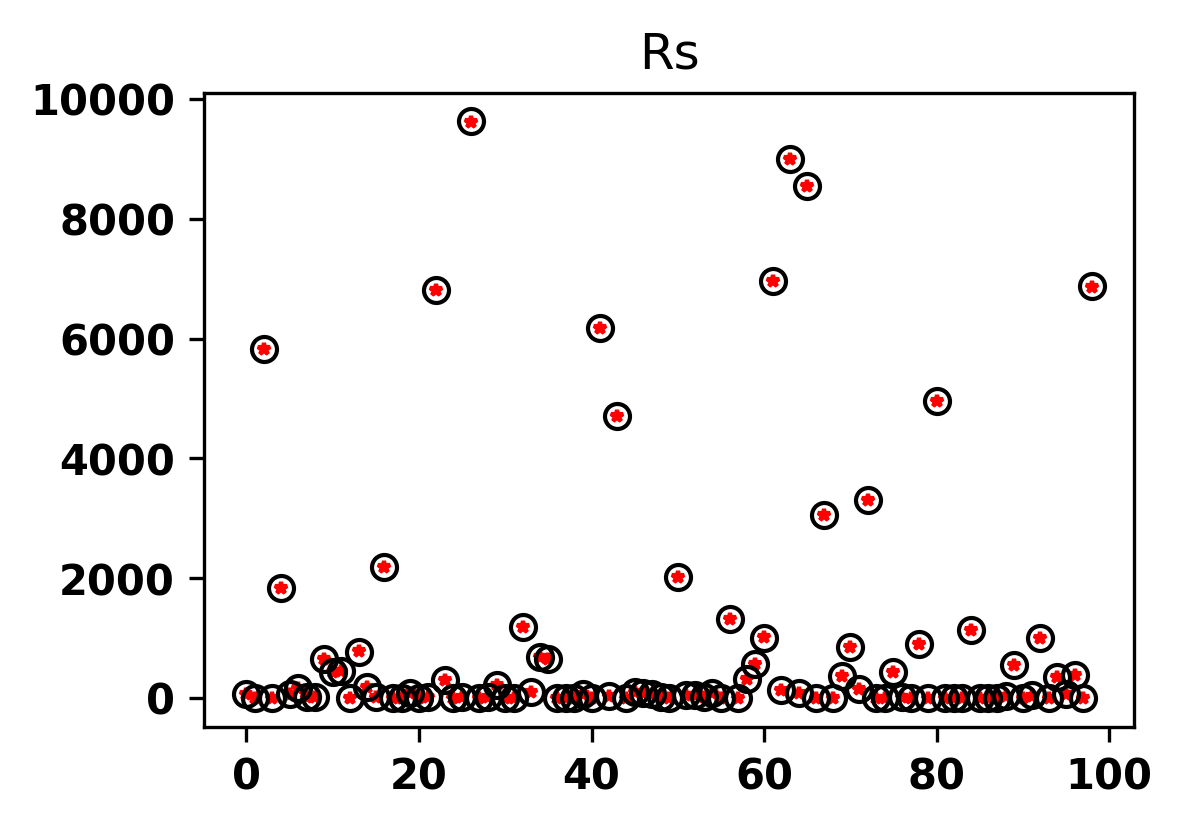

0.9999997034264374
0.7192349696946864
24.10704326942342 %
1.3613765382083536


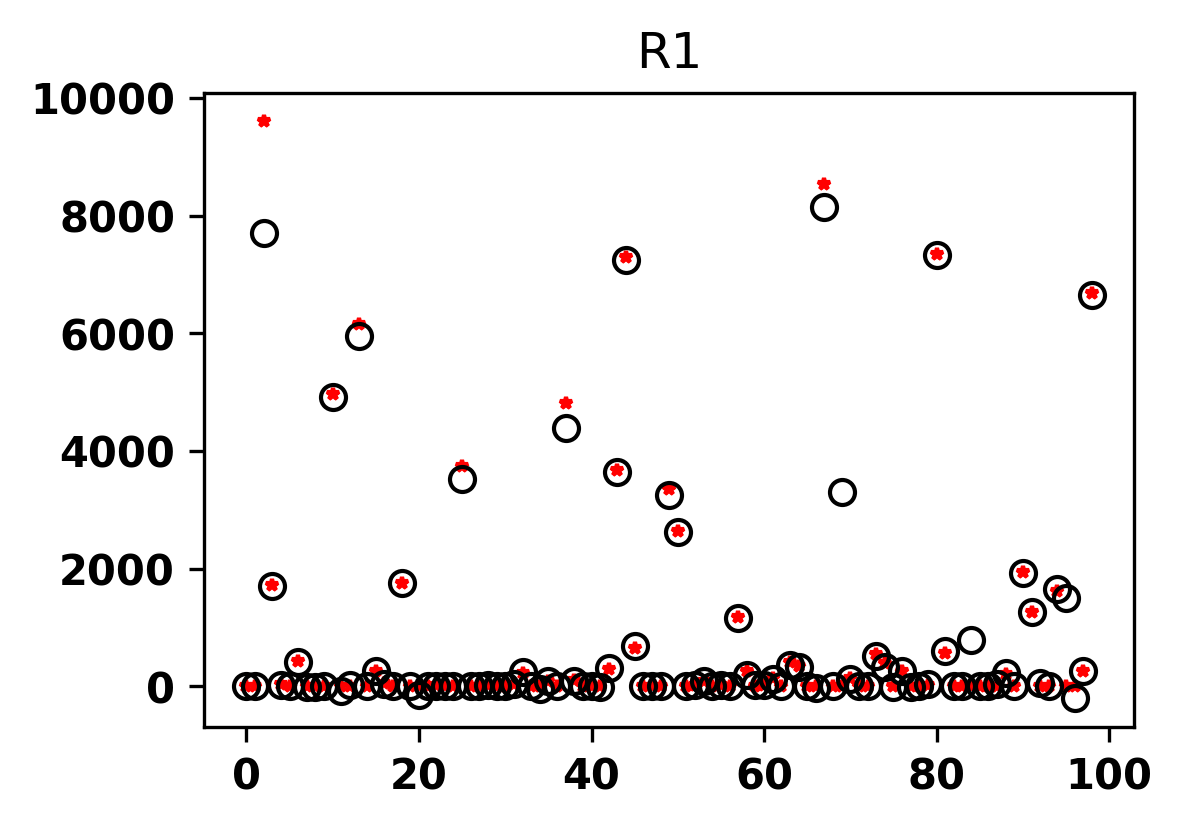

0.9545204994051424
104.67914802190629
16993.70930429939 %
181140.31158548596


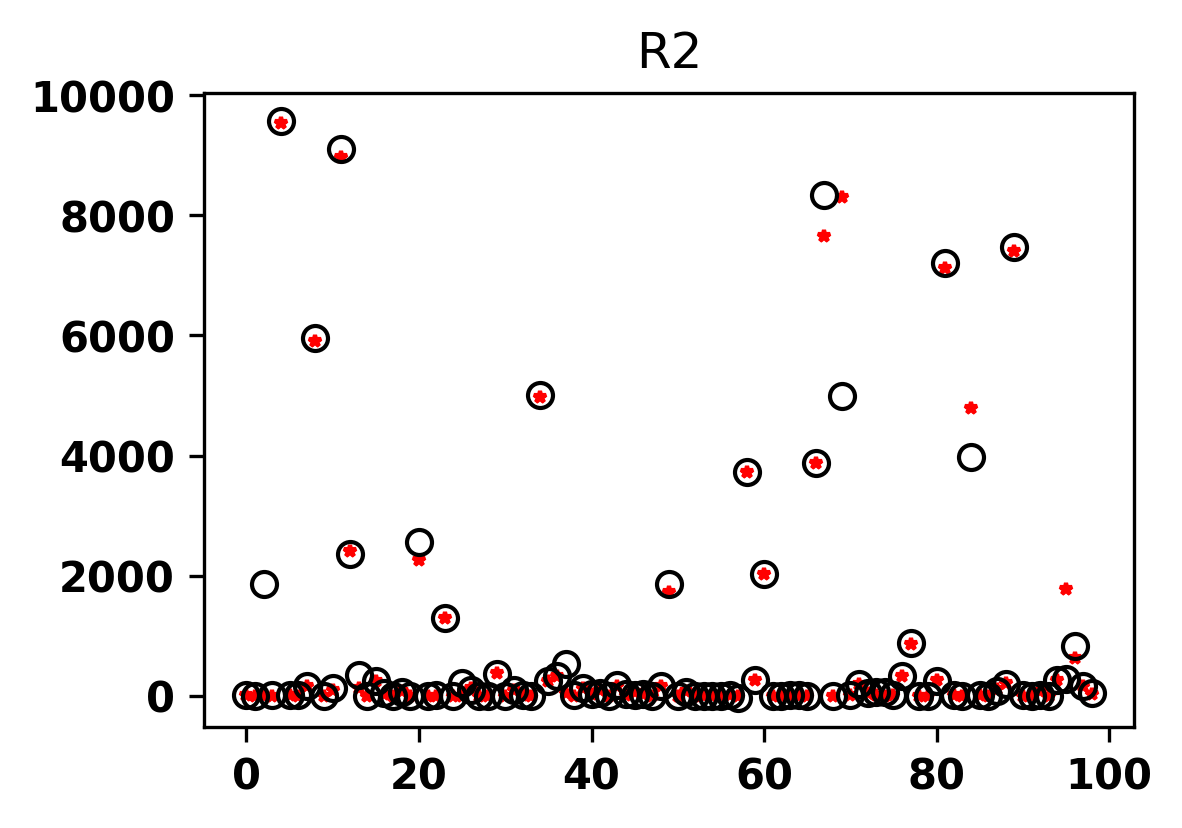

0.959992870130637
110.85176630433524
3014.475574495583 %
185440.29533360453


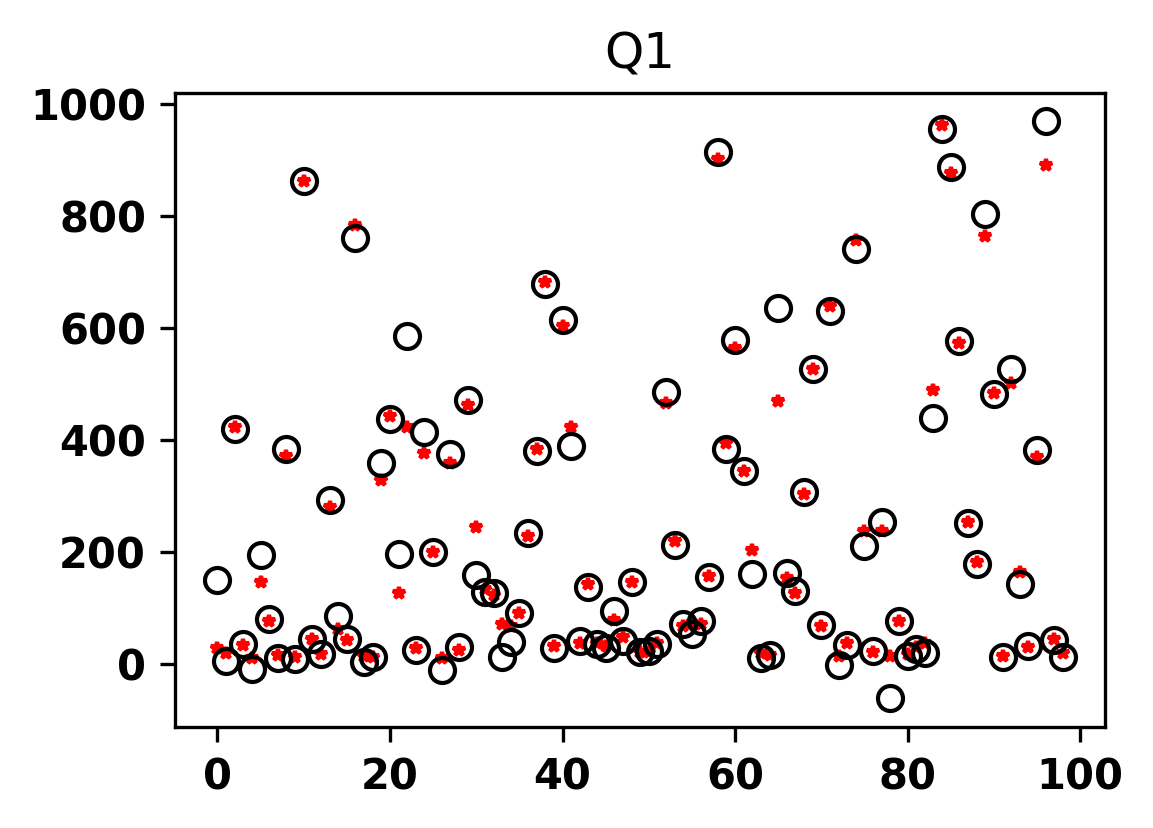

0.9818236794925715
17.550949403102287
26.64307288938723 %
1184.064064743973


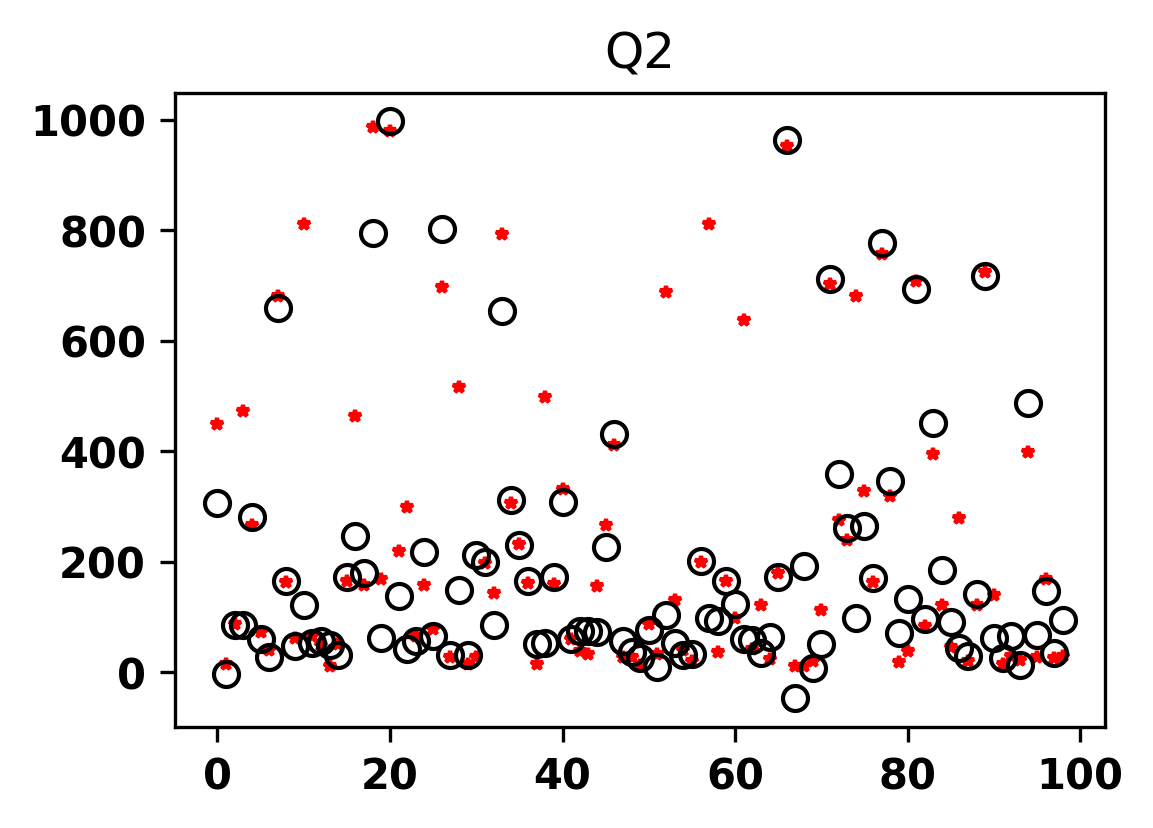

0.5682765615013505
84.81153413848813
77.95967450944751 %
29652.406717022674


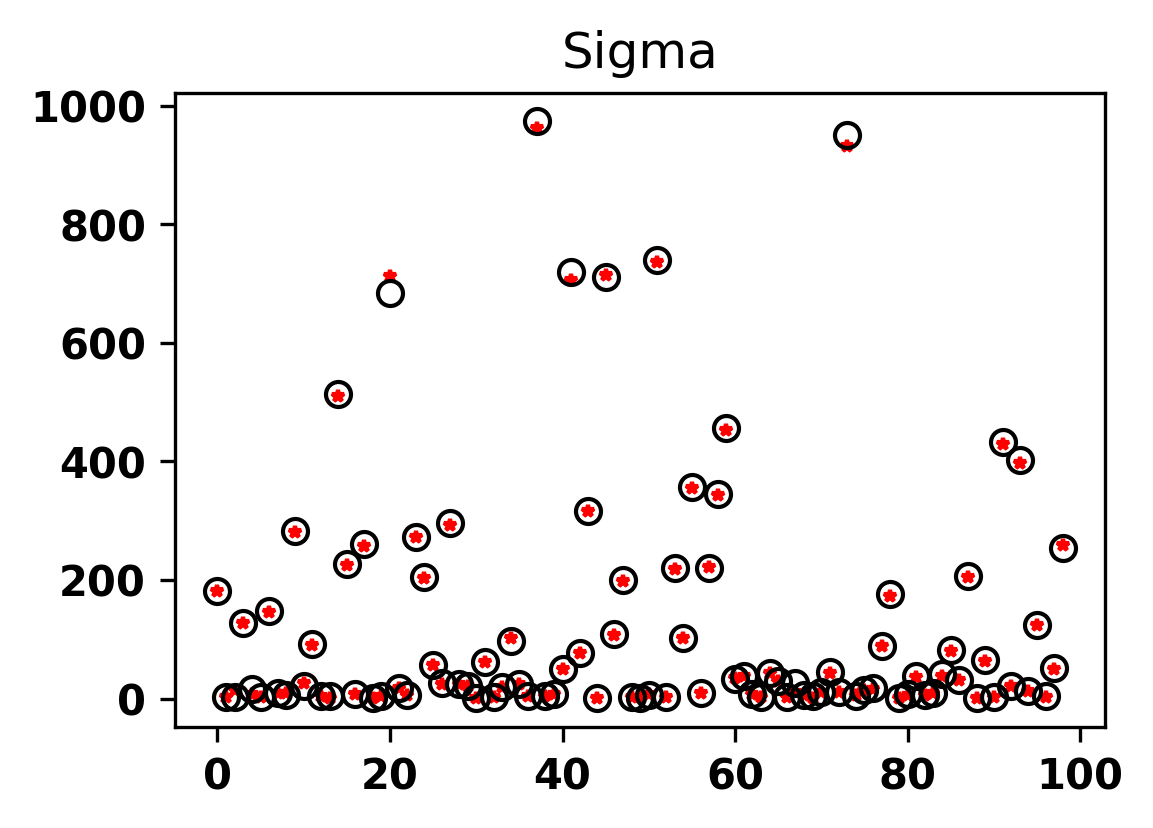

0.9994879745212776
2.173515930859126
13.45171614388074 %
22.022045186839772


In [ ]:
#Load Model
model_to_load="RegC5_alpha_BN.h5"
predict_model = tf.keras.models.load_model(model_to_load)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
y_pred=predict_model.predict(x_test)
y_pred=np.asarray(y_pred)

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
a=y_test[0:99,0]
b=y_pred[0:99,0]
plt.figure(figsize=(4, 2.8), dpi=300)
plt.title("Rs")
plt.plot(a,"*",ms=3,markeredgecolor='red')
plt.plot(b,'o', markerfacecolor='none',ms=6, markeredgecolor='black')
# plt.ylim(0,300)
# plt.xlim(0,300)
plt.show()
print(r2_score(a,b))
print(mean_absolute_error(a,b))
print(str(mean_absolute_percentage_error(a,b)*100)+" %")
print(mean_squared_error(a,b))
a=y_test[0:99,1]
b=y_pred[0:99,1]
plt.figure(figsize=(4, 2.8), dpi=300)
plt.title("R1")
plt.plot(a,"*",ms=3,markeredgecolor='red')
plt.plot(b,'o', markerfacecolor='none',ms=6, markeredgecolor='black')
# plt.ylim(0,300)
# plt.xlim(0,300)
plt.show()
print(r2_score(a,b))
print(mean_absolute_error(a,b))
print(str(mean_absolute_percentage_error(a,b)*100)+" %")
print(mean_squared_error(a,b))
a=y_test[0:99,2]
b=y_pred[0:99,2]
plt.figure(figsize=(4, 2.8), dpi=300)
plt.title("R2")
plt.plot(a,"*",ms=3,markeredgecolor='red')
plt.plot(b,'o', markerfacecolor='none',ms=6, markeredgecolor='black')
# plt.ylim(0,300)
# plt.xlim(0,300)
plt.show()
print(r2_score(a,b))
print(mean_absolute_error(a,b))
print(str(mean_absolute_percentage_error(a,b)*100)+" %")
print(mean_squared_error(a,b))

a=y_test[0:99,3]
b=y_pred[0:99,3]
plt.figure(figsize=(4, 2.8), dpi=300)
plt.title("Q1")
plt.plot(a,"*",ms=3,markeredgecolor='red')
plt.plot(b,'o', markerfacecolor='none',ms=6, markeredgecolor='black')
# plt.ylim(0,300)
# plt.xlim(0,300)
plt.show()
print(r2_score(a,b))
print(mean_absolute_error(a,b))
print(str(mean_absolute_percentage_error(a,b)*100)+" %")
print(mean_squared_error(a,b))
a=y_test[0:99,4]
b=y_pred[0:99,4]
plt.figure(figsize=(4, 2.8), dpi=300)
plt.title("Q2")
plt.plot(a,"*",ms=3,markeredgecolor='red')
plt.plot(b,'o', markerfacecolor='none',ms=6, markeredgecolor='black')
# plt.ylim(0,300)
# plt.xlim(0,300)
plt.show()
print(r2_score(a,b))
print(mean_absolute_error(a,b))
print(str(mean_absolute_percentage_error(a,b)*100)+" %")
print(mean_squared_error(a,b))

a=y_test[0:99,5]
b=y_pred[0:99,5]
plt.figure(figsize=(4, 2.8), dpi=300)
plt.title("Sigma")
plt.plot(a,"*",ms=3,markeredgecolor='red')
plt.plot(b,'o', markerfacecolor='none',ms=6, markeredgecolor='black')
# plt.ylim(0,300)
# plt.xlim(0,300)
plt.show()
print(r2_score(a,b))
print(mean_absolute_error(a,b))
print(str(mean_absolute_percentage_error(a,b)*100)+" %")
print(mean_squared_error(a,b))

In [ ]:
# Dulyawat Doonyapisut Email:charting9@gmail.com